This method explores the genre and rating associated with the movie and the customer to develop customer vector based on the content. The recommendations are generated using this customer vector.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Load movies data
movies = pd.read_csv("../demo/preproc_data/movie_data.csv", converters={"genres": literal_eval})

In [ ]:
# Load the training data
ratings_train = pd.read_csv("../demo/preproc_data/training_data.csv", converters={"genres": literal_eval, "tag": literal_eval})

# ratings_train.head()

In [7]:
# Get unique genres from the data
unique_genre = movies['genres'].explode().unique()

# Get the count of each genre
genre_distribution = ratings_train['genres'].explode().value_counts()

# Make a dict assigning an index to a genre
genre_dict = {k: v for v, k in enumerate(unique_genre)}
genre_dict

{'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'War': 13,
 'Musical': 14,
 'Documentary': 15,
 'IMAX': 16,
 'Western': 17,
 'Film-Noir': 18,
 '(no genres listed)': 19}

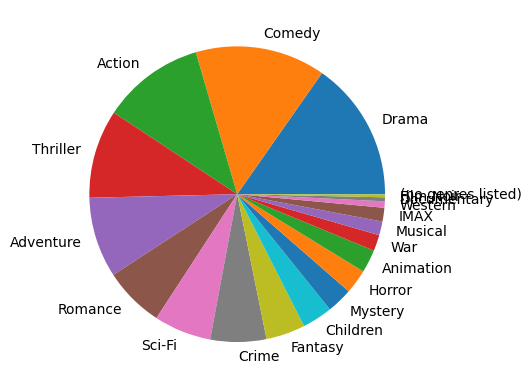

In [8]:
# import plotly.express as px 
# fig = px.pie(genre_distribution, values = genre_distribution.values, names = genre_distribution.keys(), 
#              title='Genre distribution') 
# fig.show()
plt.pie(genre_distribution.values, labels = genre_distribution.keys())
plt.show()

In [ ]:
# SLOW Code -- use skleatrn instead of this (in the next cell)

# # Creating a column per genre 
# df = ratings_train['genres'].apply(frozenset).to_frame(name='genre')
# for genre in frozenset.union(*df.genre):
#     df[genre] = df.apply(lambda _: int(genre in _.genre), axis=1)
    
# df.head()

In [ ]:
# This is not needed now

# from sklearn.preprocessing import MultiLabelBinarizer

# # Binarise labels
# mlb = MultiLabelBinarizer()
# expandedLabelData = mlb.fit_transform(ratings_train["genres"])
# labelClasses = mlb.classes_

# # Create a pandas.DataFrame from our output
# expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)

# # # View the data
# # expandedLabels.head()

# ratings_movie_genre = pd.concat([ratings_train, expandedLabels], axis=1)
# ratings_movie_genre.head()

In [11]:
movies['movie_vector'] = ""
for ind, row in movies.iterrows():
    genres = row.genres
    movie_vector = np.zeros(len(genre_dict))

    for g in genres:
        movie_vector[genre_dict[g]] = 1
    movies.at[ind, 'movie_vector'] = movie_vector

# Save the final dataframe
movies.to_csv("../demo/preproc_data/movie_vector.csv")

In [12]:
movies.head()

,movieId,title,genres,movie_vector
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
4,5,Father of the Bride Part II (1995),[Comedy],"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
user_ids = ratings_train['userId'].unique()
user_df = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
                       
for user_id in user_ids:
#     print(user_id)
    user_rating_df = ratings_train[(ratings_train['userId'] == user_id)]
#     print(user_rating_df)

    user_vector = np.zeros(len(genre_dict))
    count_vector = np.zeros(len(genre_dict))
    
    user_avg_rating = 0
    movies_rated_count = 0
    
    for _, row in user_rating_df.iterrows():
        user_avg_rating += row.rating 
        movies_rated_count += 1
        genres = row.genres

        user_movie_vector = np.zeros(len(genre_dict))
        
        for g in genres:
            user_movie_vector[genre_dict[g]] = 1
            count_vector[genre_dict[g]] += 1
            
        user_vector += user_movie_vector*row.rating

    count_vector = np.where(count_vector==0, 1, count_vector)
    user_vector = np.divide(user_vector, count_vector)
    user_avg_rating /= movies_rated_count
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]], 
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
#     print(row_df)
    user_df = pd.concat([user_df, row_df], ignore_index=True)

/var/folders/0n/_w554znn6f7fzgsl51tnyk0r0000gn/T/ipykernel_45730/3815212983.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  user_df = pd.concat([user_df, row_df], ignore_index=True)


In [14]:
# Save the final dataframe
user_df.to_csv("../demo/preproc_data/user_info.csv")

In [15]:
user_df.head()

,userId,user_vector,avg_rating,num_movies_rated
0,1,"[4.430769230769231, 4.7272727272727275, 4.6470...",4.354839,186
1,2,"[4.0, 0.0, 0.0, 4.2, 0.0, 0.0, 3.84375, 3.875,...",3.934783,23
2,3,"[2.125, 0.5, 0.5, 1.1428571428571428, 2.75, 0....",2.419355,31
3,4,"[3.909090909090909, 3.8, 3.5, 3.52380952380952...",3.554913,173
4,5,"[3.1666666666666665, 4.25, 4.0, 3.5, 4.0, 2.88...",3.600000,35


In [16]:
ratings_test = pd.read_csv("../demo/preproc_data/testing_data.csv", converters={"genres": literal_eval, "tag": literal_eval}) 
ratings_test.head()

,userId,movieId,rating,timestamp,genres,tag
0,1,50,5.0,964982931,"[Crime, Mystery, Thriller]",[]
1,1,151,5.0,964984041,"[Action, Drama, Romance, War]",[]
2,1,157,5.0,964984100,"[Comedy, War]",[]
3,1,235,4.0,964980908,"[Comedy, Drama]",[]
4,1,296,3.0,964982967,"[Comedy, Crime, Drama, Thriller]",[]


### Next  few cells for sample test data point

In [17]:
ratings_test.iloc[0]

userId                                1
movieId                              50
rating                              5.0
timestamp                     964982931
genres       [Crime, Mystery, Thriller]
tag                                  []
Name: 0, dtype: object

In [18]:
user_rating_df[user_rating_df['movieId']==6]

,userId,movieId,rating,timestamp,genres,tag
79628,610,6,5.0,1493850345,"[Action, Crime, Thriller]",[]


In [19]:
genres = user_rating_df[user_rating_df['movieId']==6].genres.values[0]
vector = np.zeros(len(genre_dict))
for g in genres:
    vector[genre_dict[g]] = 1
print(vector)

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
user_df[user_df['userId']==1].user_vector[0]

array([4.43076923, 4.72727273, 4.64705882, 4.26086957, 4.28947368,
       4.22727273, 4.56      , 4.2972973 , 4.35135135, 4.11363636,
       3.375     , 4.        , 4.23529412, 4.44444444, 4.76470588,
       0.        , 0.        , 4.25      , 5.        , 0.        ])

In [21]:
x = vector*user_df[user_df['userId']==1].user_vector[0]
np.nanmean(np.where(x!=0,x,np.nan)) 

4.254095004095004

### Test on entire test data

In [ ]:
# Load the already calculated data from csvs

# user_df = pd.read_csv("user_info.csv", converters={"user_vector": pd.array})
# movies_df = pd.read_csv("movie_vector.csv", converters={"movie_vector": pd.array})

In [22]:
algo_predictions = pd.DataFrame(columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
for ind, row in ratings_test.iterrows():
    userId = row['userId']
    movieId = row['movieId']
    og_rating = row['rating']
#     print(userId)
#     print(movieId)
    
    try:
        user_vector = user_df[user_df['userId'] == int(userId)].user_vector.values[0]
        movie_vector = movies[movies['movieId'] == int(movieId)].movie_vector.values[0]
    #     print(user_vector)
    #     print(movie_vector)

        predicted_rating = user_vector*movie_vector
    #     print(predicted_rating)
        
        if predicted_rating.any():
            predicted_rating = np.nanmean(np.where(predicted_rating!=0, predicted_rating, np.nan)) 
    #     print(predicted_rating)
        else:
            predicted_rating = 0

        row_df = pd.DataFrame([[userId, movieId, user_vector, movie_vector, og_rating, predicted_rating]], 
                    columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
        algo_predictions = pd.concat([algo_predictions, row_df], ignore_index=True)
    except:
        print("User not found: ", userId)

/var/folders/0n/_w554znn6f7fzgsl51tnyk0r0000gn/T/ipykernel_45730/3602482379.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  algo_predictions = pd.concat([algo_predictions, row_df], ignore_index=True)


In [23]:
rmse = ((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2).mean() ** .5
rmse

0.9278476410963622

In [24]:
mae = (((algo_predictions.og_rating - algo_predictions.pred_rating) ** 2) ** .5).mean()
mae

0.7173289995630376